## Part 1

You are given three files by a client:
 - 'Transactions.csv' contains a list of transactions for a bank,
 - 'EUR Exchange Rates.csv' contains a list of Euro to Pound Sterling exchange rates,
 - 'USD Exchange Rates.csv' contains a list of US Dollar to Pound Sterling exchange rates.
 
The client has asked for monthly forecasts of their data.

Your task is to clean and transform these files before they can be used for analysis.

Please produce a single csv file covering the period Jan-2015 to Feb-2019 with column headings:
 - Calendar Month
 - Sum of Withdrawals (GBP)
 - Sum of Deposits (GBP)
 - Number of Transactions
 - Account Balance for each account (GBP)
 
You may assume that the Account Balance is zero on 31-Dec-2014.

In [131]:
# Answer for Part 1
# ~~~
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import re

# conversion functions
def ConverttoGBP(amt,currtype,idx):
    if currtype == "USD":
        return USDtoGBP(idx,amt)
    elif currtype == "EUR":
        return EURtoGBP(idx,amt)
    elif currtype == "GBP":
        return amt
    else:
        raise Exception('Currency type cannot be converted.')

def USDtoGBP(date,curr):
    EV = USD_ER.iloc[USD_ER.index.get_indexer([date], method='nearest')]
    return (curr / EV["USD-GBP"][0])

def EURtoGBP(date,curr):
    EV = EUR_ER.iloc[EUR_ER.index.get_indexer([date], method='nearest')]
    return (curr / EV["EUR-GBP"][0])

# read in csv data
transactions = pd.read_csv(r'Transactions.csv')
# convert date column to datetime format without time
transactions['DATE']= pd.to_datetime(transactions['DATE'],dayfirst=True)

USD_ER = pd.read_csv(r'USD_Exchange_Rates.csv')
USD_ER['Date']= pd.to_datetime(USD_ER['Date'])

EUR_ER = pd.read_csv(r'EUR_Exchange_Rates.csv')
EUR_ER['Date']= pd.to_datetime(EUR_ER['Date'])

### faster approach to obtaining the monthly dates than iteration search
# set the index to date for fast lookup
transactions = transactions.set_index(['DATE'])
# sort transactions to allow for fast lookup
transactions.sort_index(inplace=True, ascending=True)

# also set index to dates for conversion rates for faster lookup method later
USD_ER = USD_ER.set_index(['Date'])
EUR_ER = EUR_ER.set_index(['Date'])

# create an Empty DataFrame for output
output = pd.DataFrame(columns = ["Calendar Month", "Sum of Withdrawals (GBP)", "Sum of Deposits (GBP)", \
           "Number of Transactions", "Account Balance for each account (GBP)"])

# setting up date ranges that are requested (+1 to end for search range) - date range Start / End
dtrange = (pd.date_range(start='2015-01-01', end='2019-03-01', freq="MS"))

# popupate temp individual account balances with unique account nos
balances = dict.fromkeys(transactions["Account No"].unique(), 0)

# run sum scripts for each month for the requested range
for i in range(len(dtrange)-1):
    # reset vars for temp holding data for output
    sumwithdraw = 0
    sumdeposit = 0
    totaltrans = 0
    
    # gather all transactions over a single calendar month
    monthtrans = transactions.loc[dtrange[i]:dtrange[i+1]]
    
    # iterate through transactions, vectorization can be applied if number of transactions increases
    for index, row in monthtrans.iterrows():

        try:
            # strip away extra characters
            amount = float(re.sub('[^\d\.]', '', str(row[1])))
            # convert foreign currency to GBP if amount is a non zero
            if amount != 0:
                amount = ConverttoGBP(amount,row[3],index)
                sumwithdraw += amount
                balances[row[0]] -= amount
                totaltrans += 1
        # if the transaction amount is empty or unreadable just continue with calculation
        except ValueError:
            pass

        try:
            amount = float(re.sub('[^\d\.]', '', str(row[2])))
            if amount != 0:
                amount = ConverttoGBP(amount,row[3],index)
                sumdeposit += amount
                balances[row[0]] += amount
                totaltrans += 1
        # if the transaction amount is empty or unreadable just continue with calculation
        except ValueError:
            pass
        
    # add a new entry for the output csv
    output.loc[len(output.index)] = [dtrange[i], sumwithdraw, sumdeposit, totaltrans, balances.copy()]

# output to csv file
output.to_csv('output.csv', index=False)

# overall more withdrawals were made than deposits so the accounts are all negative by the end
# this feels wrong and the reason I tried to clarify over email


## Part 2

For this task you are given a single file containg patient data: 'diabetes.csv'.

The 'Outcome' column is 1 if the patient has diabetes, and 0 if they do not. The aim of this task is to build a model that will determine the probability of someone having diabetes or not, based on all other variables given in the dataset.

Some code has been provided for you, but please feel free to edit it and investigate.

We first split up the data into a training set and test set. Please run the code below.

In [5]:
import pandas as pd

# Load diabetes.csv into a dataframe
data = pd.read_csv('diabetes.csv')
print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [6]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and labels (y)
X = data.drop(columns='Outcome')
y = data['Outcome']

# Split data as 80% training set, and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

We are given two models to compare. Please run the code below.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def random_forest_predict(X_train, y_train, X_test, y_test):

    rfc = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42)
    rfc.fit(X_train, y_train)

    return rfc.predict_proba(X_test)[:, 1]

def knn_predict(X_train, y_train, X_test, y_test):

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    return knn.predict_proba(X_test)[:, 1]

rf_probabilities = random_forest_predict(X_train, y_train, X_test, y_test)
knn_probabilities = knn_predict(X_train, y_train, X_test, y_test)

Please compare y_test to rf_probabilities and knn_probabilities and give a recommendation of which model to use. You may want to use different metrics and/or produce plots to back up your answer.

rf_probabilities
Negative prediction average: 0.2643017477400081
Positive prediction average: 0.4622753869805488

knn_probabilities
Negative prediction average: 0.22244897959183674
Positive prediction average: 0.5178571428571429

These are also shown as the triangle on the following box plots:


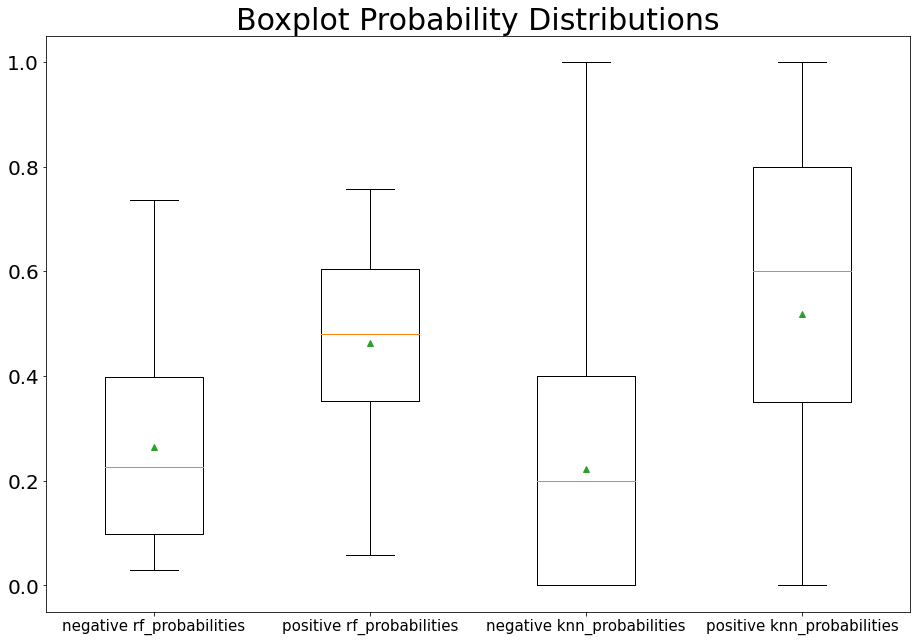


####################

Boxplots are a good way of showing the overall accuracy of the two models, however it is also good to see a more detailed view of the individual results on a histogram.

Interpretation:
The closer the blue bars are to 0 the more accurate the model is to correctly predicting a person NOT developing diabetes.
The closer the red bars are to 1 the more accurate the model is to correctly predicting a person developing diabetes.


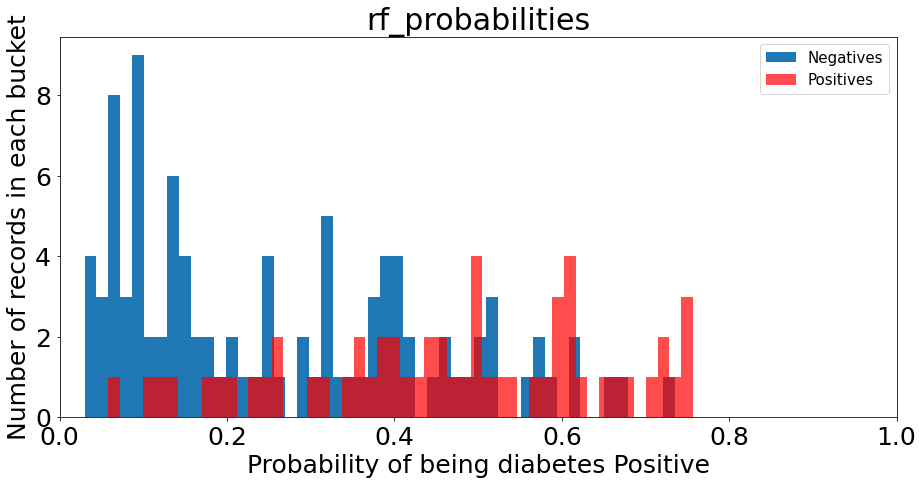

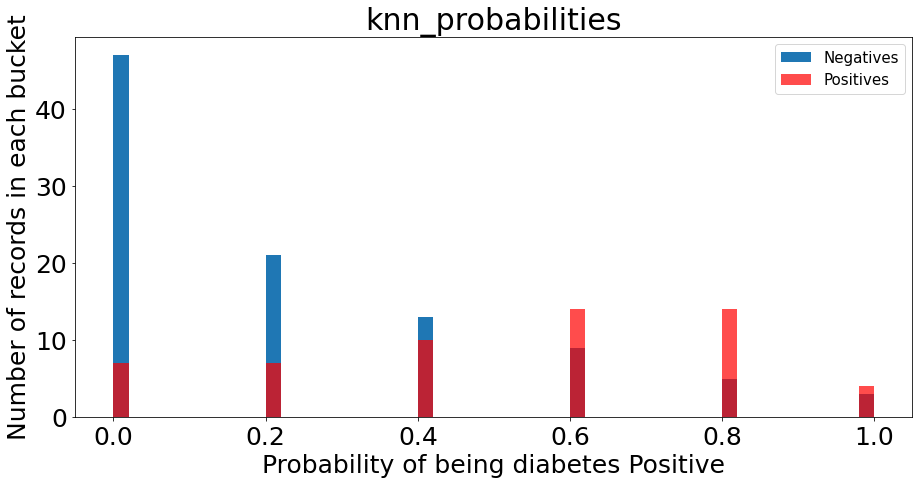


####################

~~~ Analysis ~~~


In [130]:
# Answer for Part 2
import matplotlib.pyplot as plt
import numpy as np

print("rf_probabilities")
print("Negative prediction average: " + str(np.mean(rf_probabilities[y_test==0])))
print("Positive prediction average: " + str(np.mean(rf_probabilities[y_test==1])))

print("\nknn_probabilities")
print("Negative prediction average: " + str(np.mean(knn_probabilities[y_test==0])))
print("Positive prediction average: " + str(np.mean(knn_probabilities[y_test==1])))

print("\nThese are also shown as the triangle on the following box plots:")

fig, ax = plt.subplots()
ax.boxplot([rf_probabilities[y_test==0],rf_probabilities[y_test==1],
            knn_probabilities[y_test==0],knn_probabilities[y_test==1]], showmeans=True)
ax.set_title('Boxplot Probability Distributions', fontsize=30)
plt.xticks([1, 2, 3, 4], 
           ['negative rf_probabilities', 'positive rf_probabilities',
            'negative knn_probabilities', 'positive knn_probabilities'])
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=20)
fig.subplots_adjust(0, 0, 2, 2)
plt.show()

print("\n####################\n")

print("Boxplots are a good way of showing the overall accuracy of the two models, however it is also good to see a more detailed view of the individual results on a histogram.")

print("\nInterpretation:")
print("The closer the blue bars are to 0 the more accurate the model is to correctly predicting a person NOT developing diabetes.")
print("The closer the red bars are to 1 the more accurate the model is to correctly predicting a person developing diabetes.")

# rf_probabilities

plt.figure(figsize=(15,7))
plt.hist(rf_probabilities[y_test==0], bins=50, label='Negatives')
plt.hist(rf_probabilities[y_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.title("rf_probabilities", fontsize=30)
plt.xlabel('Probability of being diabetes Positive', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.xlim([0, 1])
plt.show()

# knn_probabilities

plt.figure(figsize=(15,7))
plt.hist(knn_probabilities[y_test==0], bins=50, label='Negatives')
plt.hist(knn_probabilities[y_test==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.title("knn_probabilities", fontsize=30)
plt.xlabel('Probability of being diabetes Positive', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show()

print("\n####################\n")

print("~~~ Analysis ~~~")

# Note: Analysis is written up in the next cell using markdown instead of print statements


Note: Running the train / test split cell sometimes changes the probabilities.
After looking through a good number of splits I found that the example above appears to summarise the models best.
I considered creating several rf and knn models and averaging out their results but I dont think that is part of this task.

###### Initial analysis

Initial analysis of the histogram data distributions suggests that both models are fairly accurate in correctly predicting that a patient will NOT develop diabetes as both rf_probabilities and knn_probabilities have 75% of their true negative predictions at or below 0.4 confidence.

However we begin to notice a major difference in the positive probabilities where knn appears to correctly predict positive diabetes far more often than rf especially around the median and Q3. This initially makes it seem like the better model for correctly predicting positive diabetes.

Also note that while the averages are quite similar, the knn model slightly outperforms rf in both correctly predicting positive and negative diabetes.

---
###### Model aggressiveness

An important factor that is obvious on the histograms and also seen on the boxplot is the fact that knn appears to far more aggressively predict its probabilities, whether they are correct or not.

You can see that rf does not make a single prediction over 0.8 for either positive or negative diabetes while knn makes a lot of true positive diabetes predictions and a smaller number of false positive diabetes predictions.

Viewing the graphs overall we can see that knn is noticeably more accurate in predicting positive diabetes than rf for this dataset.

---
###### Positive/negative train test samples

Something to note is that there are about double as many negative diabetes dataset samples available to train and test on as positive.

This is why the red bars appear to be smaller than the blue on both histograms, and may explain the strong bias of rf predictions to the side of negative diabetes.

---
###### Conclusion

Overall knn appears to be more accurate than rf for this dataset, the only major downside that I can see knn having over rf is the fact that it sometimes makes false predictions with absolute confidence (false 0.0 and 1.0 predictions) which can be misleading when checking individual results and cause issues for patients.

With a larger and more balanced dataset rf may potentially become more accurate however for the current dataset I must conclude with recommending K-Nearest Neighbours as on average it provides a more accurate result over Random Forest.